Diego Toribio <br>
Professor Sam Keene <br>
Frequentist Machine Learning <br>
Project 5: Random Forest

<ins>Project Description</ins>: Replicate figure 15.3 comparing random forests and gradient boosted trees. You can use whatever package you wish, you don't have to use xgboost if you'd rather keep everything in sci-kit learn. Compare the feature importance found by random forests and gradient boosted trees. If there are significant differences, can you offer an explanation?
Select another dataset and repeat the analysis. Pick a dataset we have not yet studied in class.


## Califonria Housing Dataset

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import transforms
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2

np.random.seed(13)

In [ ]:
# Loading Dataset
ch = fetch_california_housing(as_frame=True)
X1, y1 = ch.data, ch.target

print(f"X Shape: {X1.shape}")
print(f"y Shape: {y1.shape}")
print("Features:", list(X1.columns))

feature_names = list(X1.columns)


# Data Split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.2, random_state=13
)

print(f"X Train: {X1_train.shape}")
print(f"X Test: {X1_test.shape}")

X Shape: (20640, 8)
y Shape: (20640,)
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X Train: (16512, 8)
X Test: (4128, 8)


In [ ]:
config = [
    {'name': 'RF m=2', 'model': rfr, 'params': {'max_features': 2}},
    {'name': 'RF m=6', 'model': rfr, 'params': {'max_features': 6}},
    {'name': 'GBM depth=4', 'model': gbr, 'params': {'max_depth': 4}},
    {'name': 'GBM depth=6', 'model': gbr, 'params': {'max_depth': 6}}
]

min_estimators = 1
max_estimators = 1000

### Model Performance Comparison

In [ ]:
def train_models(config, X_train, y_train, X_val, y_val, min_estimators, max_estimators):
    trained_models = {}
    losses = {}

    for model_config in config:
        name = model_config["name"]
        model_class = model_config["model"]
        params = model_config["params"]

        params['warm_start'] = True

        print(f"Training model: {name}")
        model = model_class(**params)
        trained_models[name] = model
        losses[name] = []

        for i in tqdm(
            range(min_estimators, max_estimators + 1),
            desc=f"Estimator Count for {name}",
        ):
            model.set_params(n_estimators=i)
            model.fit(X_train, y_train)

            predictions = model.predict(X_val)
            validation_loss = mae(y_val, predictions)
            losses[name].append(validation_loss)

    return trained_models, losses





trained_models1, losses1 = train_models(
    config, X1_train, y1_train, X1_test, y1_test, min_estimators, max_estimators
)

Training model: RF m=2


Estimator Count for RF m=2: 100%|██████████| 1000/1000 [11:56<00:00,  1.40it/s]


Training model: RF m=6


Estimator Count for RF m=6: 100%|██████████| 1000/1000 [13:04<00:00,  1.27it/s]


Training model: GBM depth=4


Estimator Count for GBM depth=4: 100%|██████████| 1000/1000 [03:49<00:00,  4.35it/s]


Training model: GBM depth=6


Estimator Count for GBM depth=6: 100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]


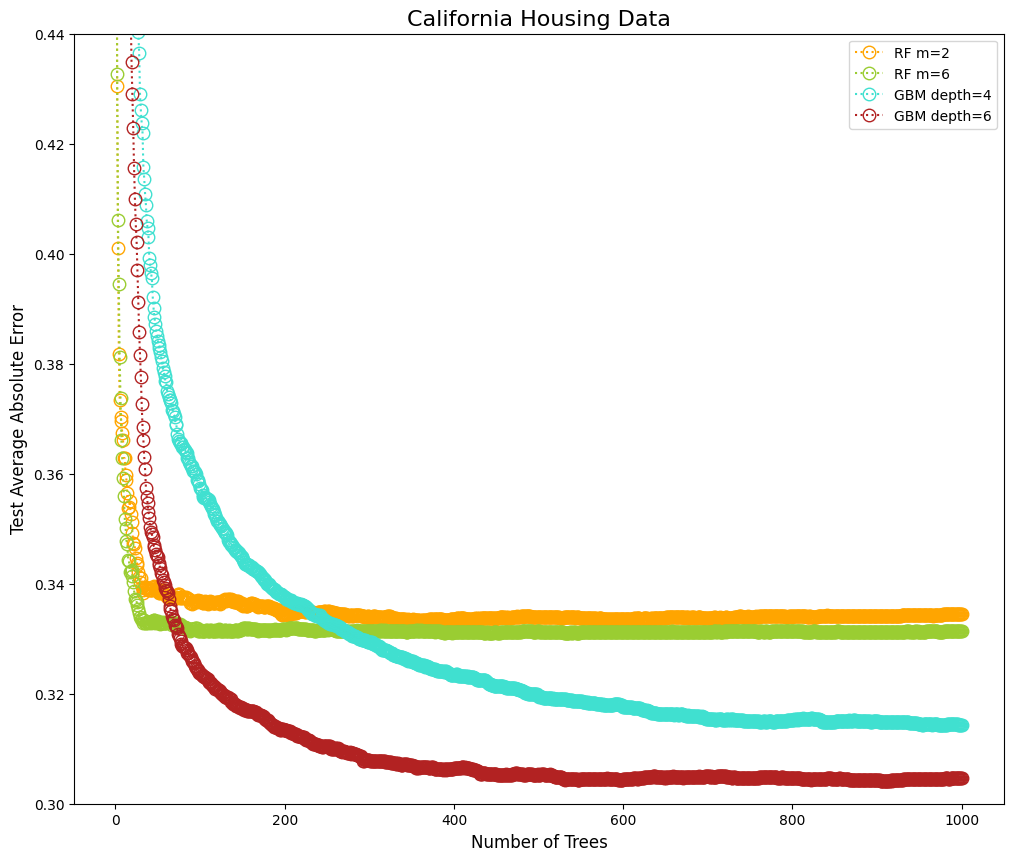

In [ ]:
def plot_results(losses, min_estimators, max_estimators):
    color_map = {
        'RF m=2': 'orange',
        'RF m=6': 'yellowgreen',
        'GBM depth=4': 'turquoise',
        'GBM depth=6': 'firebrick'
    }

    plt.figure(figsize=(12, 10))
    n_est = range(min_estimators, max_estimators + 1)

    for name, lss in losses.items():
        plt.plot(
            n_est, lss,
            label=name,
            color=color_map.get(name, 'black'),
            linestyle=':',
            marker='o',
            markersize=9,
            fillstyle='none'
        )

    plt.xlabel("Number of Trees", fontsize=12)
    plt.ylabel("Test Average Absolute Error", fontsize=12)
    plt.title("California Housing Data", fontsize=16)
    plt.ylim(0.30, 0.44)
    plt.yticks(np.arange(0.30, 0.44, 0.02))
    legend = plt.legend()


    plt.show()

plot_results(losses1, min_estimators, max_estimators)

### Feature Importance

In [ ]:
def plot_feature_importance(models, feature_names):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()

    for i, (name, model) in enumerate(models.items()):
        # Calculate the relative importance of features
        importance = model.feature_importances_
        max_importance = np.max(importance)
        relative_importance = sorted(zip(100 * importance / max_importance, feature_names),
                                     key=lambda x: x[0], reverse=True)

        # Prepare data for the plot
        yticks = np.arange(len(relative_importance))
        yticklabels = [ri[1] for ri in relative_importance]
        bar_sizes = [ri[0] for ri in relative_importance]

        ax = axes[i]
        ax.barh(yticks, bar_sizes, height=0.8, color='red')
        plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
        ax.set_xlim([0, 100])
        ax.set_ylim([-0.5, len(relative_importance) - 0.5])
        ax.tick_params(left=False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_bounds(0, 100)
        ax.set_xlabel('Relative Importance', fontsize=10)
        ax.set_title(name, fontsize=12)

        # Adjust font size and positioning of tick labels
        for e in ax.get_yticklabels() + ax.get_xticklabels():
            e.set_fontsize(8)
        offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
        for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + [ax.spines['bottom']]:
            e.set_transform(e.get_transform() + offset)

    plt.tight_layout()
    plt.show()


plot_feature_importance(trained_models1, feature_names)

## Iris Dataset

In [ ]:
from sklearn.datasets import load_iris


iris = load_iris(as_frame=True)
X2, y2 = iris.data, iris.target

print(f"X Shape: {X2.shape}")
print(f"y Shape: {y2.shape}")
print("Features:", list(X2.columns))

feature_names2 = list(X2.columns)


# Data Split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=13
)

print(f"X Train: {X2_train.shape}")
print(f"X Test: {X2_test.shape}")

X Shape: (150, 4)
y Shape: (150,)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
X Train: (120, 4)
X Test: (30, 4)


In [ ]:
trained_models2, losses2 = train_models(
    config, X2_train, y2_train, X2_test, y2_test, min_estimators, max_estimators
)

Training model: RF m=2


Estimator Count for RF m=2: 100%|██████████| 1000/1000 [00:23<00:00, 42.08it/s]


Training model: RF m=6


Estimator Count for RF m=6: 100%|██████████| 1000/1000 [00:24<00:00, 41.29it/s]


Training model: GBM depth=4


Estimator Count for GBM depth=4: 100%|██████████| 1000/1000 [00:06<00:00, 144.78it/s]


Training model: GBM depth=6


Estimator Count for GBM depth=6: 100%|██████████| 1000/1000 [00:04<00:00, 221.39it/s]


### Model Performance Comparison

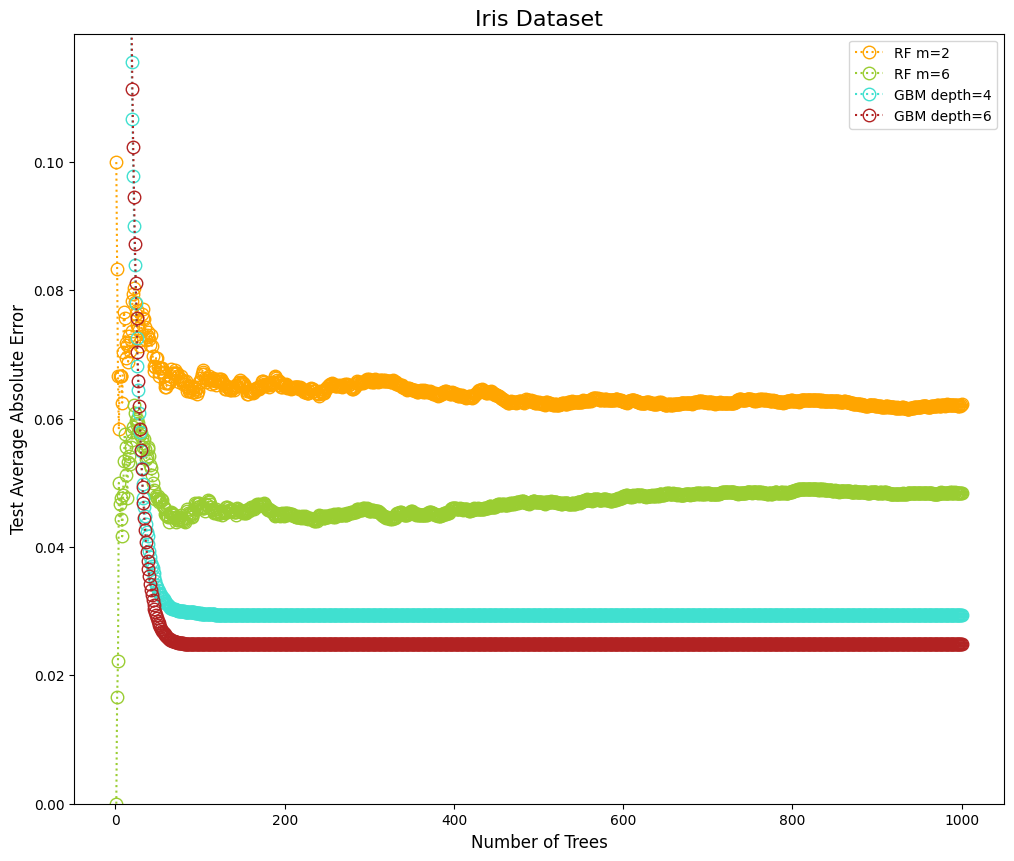

In [ ]:
def plot_results(losses, min_estimators, max_estimators):
    color_map = {
        'RF m=2': 'orange',
        'RF m=6': 'yellowgreen',
        'GBM depth=4': 'turquoise',
        'GBM depth=6': 'firebrick'
    }

    plt.figure(figsize=(12, 10))
    n_est = range(min_estimators, max_estimators + 1)

    for name, lss in losses.items():
        plt.plot(
            n_est, lss,
            label=name,
            color=color_map.get(name, 'black'),
            linestyle=':',
            marker='o',
            markersize=9,
            fillstyle='none'
        )

    plt.xlabel("Number of Trees", fontsize=12)
    plt.ylabel("Test Average Absolute Error", fontsize=12)
    plt.title("Iris Dataset", fontsize=16)
    plt.ylim(0.0, 0.12)
    plt.yticks(np.arange(0.0, 0.12, 0.02))
    legend = plt.legend()


    plt.show()


plot_results(losses2, min_estimators, max_estimators)

### Feature Importance

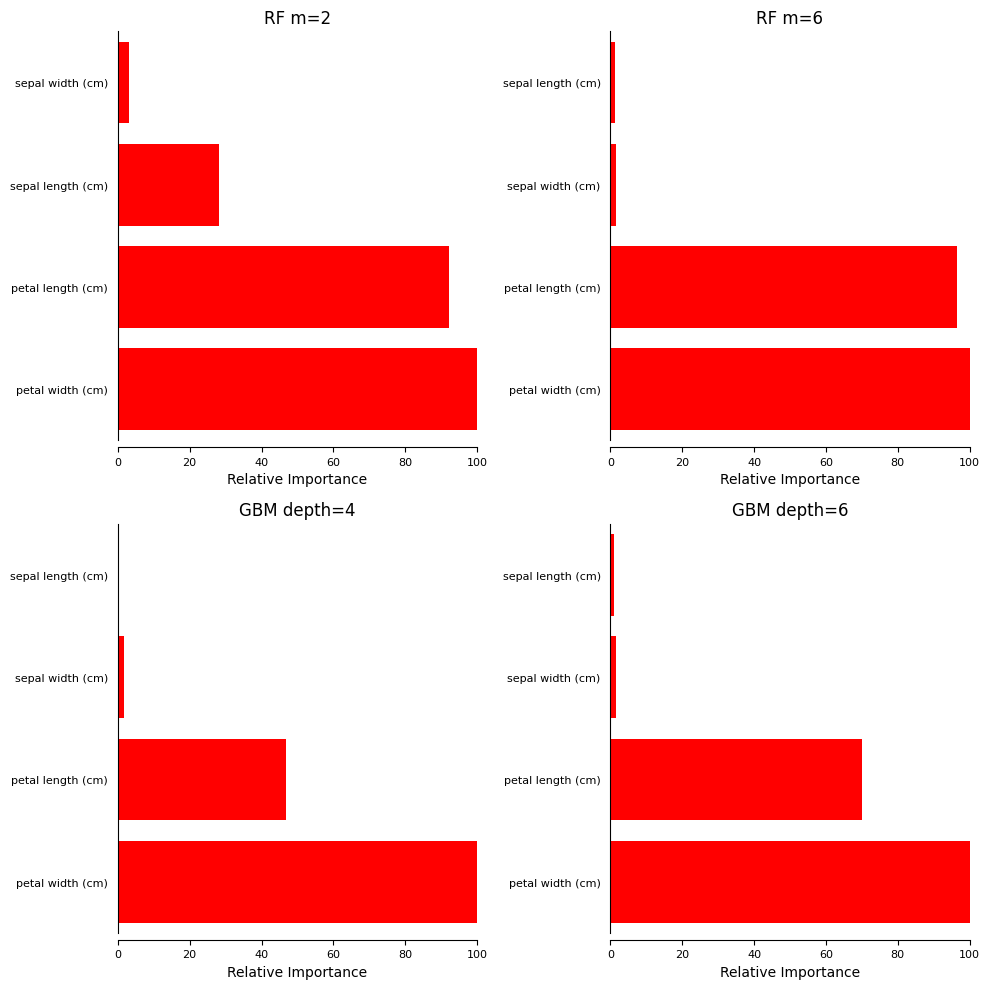

In [ ]:
plot_feature_importance(trained_models2, feature_names2)